In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from numpy import genfromtxt
from diff_tvr import *

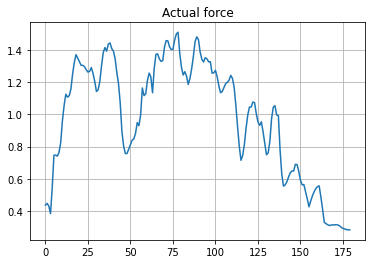

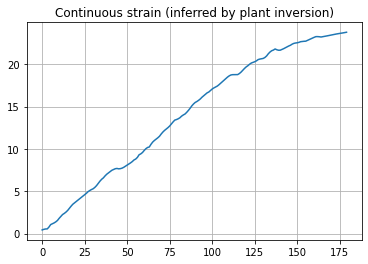

In [223]:
force = genfromtxt('force.csv', delimiter=',')
strain = genfromtxt('strain.csv', delimiter=',')

plt.plot(force); plt.grid(); plt.title('Actual force'); plt.show()
plt.plot(strain); plt.grid(); plt.title('Continuous strain (inferred by plant inversion)'); plt.show()

In [3]:
def v2f(state,u,dt):
    return state -4*state*dt + u*dt

### Fit the reference strain rate (assume it is constant)

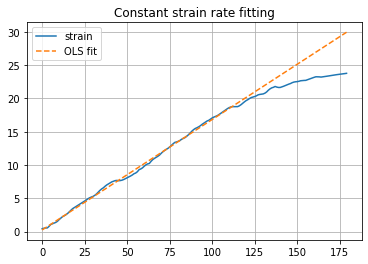

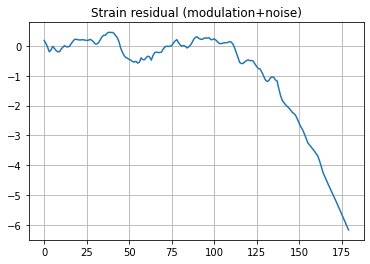

In [236]:
from scipy import stats
y_fit = strain[:100]
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(y_fit.shape[0]),y_fit)
strain_ref = intercept+np.arange(strain.shape[0])*slope
plt.plot(strain); 
plt.plot(strain_ref,'--')
plt.legend(['strain','OLS fit'])
plt.title('Constant strain rate fitting'); plt.grid(); plt.show()

v_ref = slope*np.ones(strain.shape[0]) # we model reference as a constant strain rate
strain_res = strain - strain_ref # residual = impedance modulation + noise
plt.plot(strain_res); plt.title('Strain residual (modulation+noise)'); plt.grid()

Text(0.5, 1.0, 'Constant strain rate model')

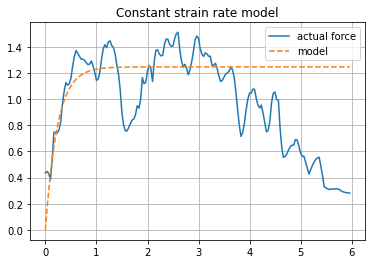

In [235]:
N = 180
dt = 0.0333
t = np.arange(0,N*dt,dt)

states = [0]

for i in range(t.shape[0]-1):
    states.append(v2f(states[-1],v_ref[i]/dt,dt))

plt.plot(t,force)
plt.plot(t,np.array(states),'--')
plt.legend(['actual force','model'])
plt.grid(); plt.title('Constant strain rate model')

### Fit the strain rate modulation

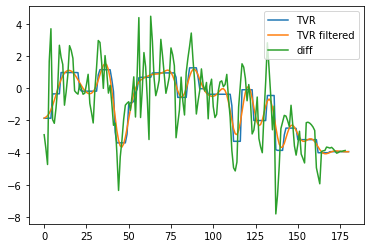

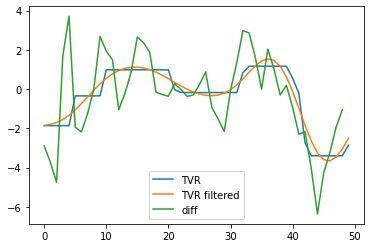

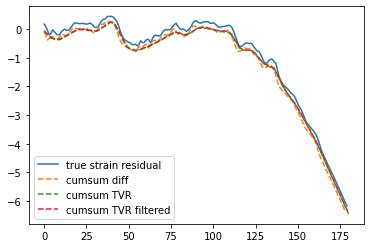

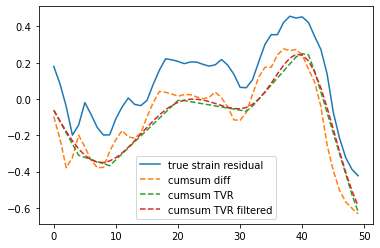

In [26]:
# Data
dx = dt
data_noisy = strain_res
n = len(data_noisy)

# Derivative with TVR
diff_tvr = DiffTVR(n,dx)
(v_imp,_) = diff_tvr.get_deriv_tvr(
    data=data_noisy, 
    deriv_guess=np.full(n+1,0.0), 
    alpha=0.01,
    no_opt_steps=100
    )

b, a = signal.ellip(4, 0.01, 120, 0.125)  # LPF
v_impf = signal.filtfilt(b, a, v_imp, padlen=10)

# Plot TVR derivative
fig2 = plt.figure()
plt.plot(v_imp,label='TVR')
plt.plot(v_impf,label='TVR filtered')
plt.plot(np.diff(strain_res)/dt,label='diff')
plt.legend()
plt.show()

plt.plot(v_imp[:50],label='TVR')
plt.plot(v_impf[:50],label='TVR filtered')
plt.plot(np.diff(strain_res[:50])/dt,label='diff')
plt.legend()
plt.show()

integrated_diff = np.cumsum(np.diff(strain_res))
integrated_tvr = np.cumsum(v_imp*dt)
integrated_tvrf = np.cumsum(v_impf*dt)

plt.plot(strain_res,label='true strain residual')
plt.plot(integrated_diff,'--',label='cumsum diff')
plt.plot(integrated_tvr,'--',label='cumsum TVR')
plt.plot(integrated_tvrf,'--',label='cumsum TVR filtered')
plt.legend()
plt.show()

plt.plot(strain_res[:50],label='true strain residual')
plt.plot(integrated_diff[:50],'--',label='cumsum diff')
plt.plot(integrated_tvr[:50],'--',label='cumsum TVR')
plt.plot(integrated_tvrf[:50],'--',label='cumsum TVR filtered')
plt.legend()
plt.show()

### Now put both the reference strain rate (v_ref) and strain rate modulation (v_imp) together

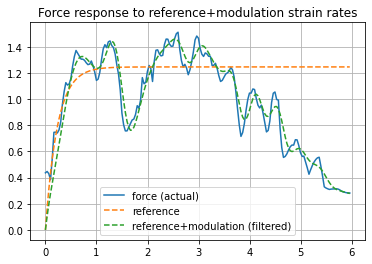

In [214]:
N = 180
dt = 0.0333
t = np.arange(0,N*dt,dt)

states = [0]
states_res = [0]

for i in range(t.shape[0]-1):
    states.append(v2f(states[-1],v_ref[i]/dt,dt))
    states_res.append(v2f(states_res[-1],v_ref[i]/dt+v_impf[i],dt))

plt.plot(t,force,label='force (actual)')
plt.plot(t,np.array(states),'--',label='reference')
plt.plot(t,np.array(states_res),'--',label='reference+modulation (filtered)')
plt.grid(); plt.title('Force response to reference+modulation strain rates')
plt.legend()

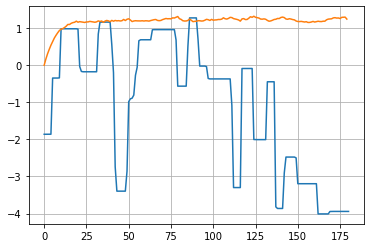

In [211]:
# plt.plot(v_impf)
plt.plot(v_imp)
# plt.plot(-5*(np.array(states)-force))
# plt.plot((force-0.1*strain)/0.5)
# plt.plot(dforce)
plt.plot(np.array(states))
# plt.plot(force)
plt.grid()

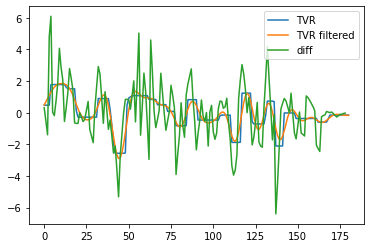

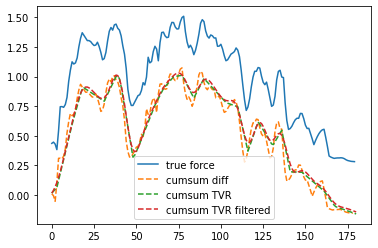

In [201]:
# Data
dx = dt
data_noisy = force
n = len(data_noisy)

# Derivative with TVR
diff_tvr = DiffTVR(n,dx)
(dforce,_) = diff_tvr.get_deriv_tvr(
    data=data_noisy, 
    deriv_guess=np.full(n+1,0.0), 
    alpha=0.01,
    no_opt_steps=100
    )

b, a = signal.ellip(4, 0.01, 120, 0.125)  # LPF
dforcef = signal.filtfilt(b, a, dforce, padlen=10)

# Plot TVR derivative
fig2 = plt.figure()
plt.plot(dforce,label='TVR')
plt.plot(dforcef,label='TVR filtered')
plt.plot(np.diff(force)/dt,label='diff')
plt.legend()
plt.show()

integrated_diff = np.cumsum(np.diff(force))
integrated_tvr = np.cumsum(dforce*dt)
integrated_tvrf = np.cumsum(dforcef*dt)

plt.plot(force,label='true force')
plt.plot(integrated_diff,'--',label='cumsum diff')
plt.plot(integrated_tvr,'--',label='cumsum TVR')
plt.plot(integrated_tvrf,'--',label='cumsum TVR filtered')
plt.legend()
plt.show()

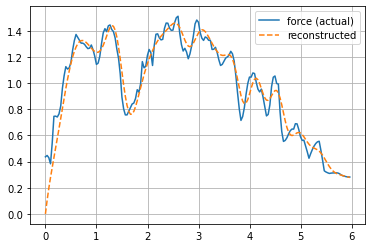

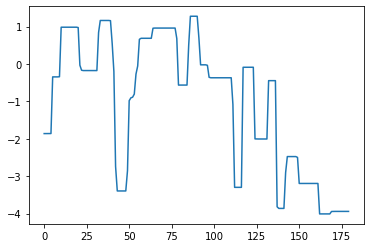

In [221]:
N = 180
dt = 0.0333
t = np.arange(0,N*dt,dt)

states = [0]

for i in range(t.shape[0]-1):
    states.append(v2f(states[-1],v_ref[i]/dt+v_impf[i],dt))
    

plt.plot(t,force,label='force (actual)')
plt.plot(t,np.array(states),'--',label='reconstructed')
plt.grid(); 
plt.legend(); plt.show()

plt.plot(v_imp[:-1])

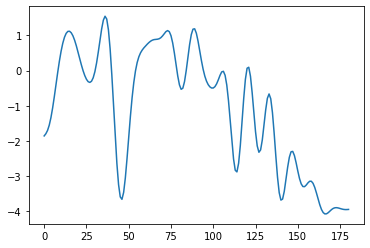

In [222]:
plt.plot(v_impf)

Optimization terminated successfully.
         Current function value: 213.622772
         Iterations: 46
         Function evaluations: 87
[0.09459594 0.60476487 0.82633005]


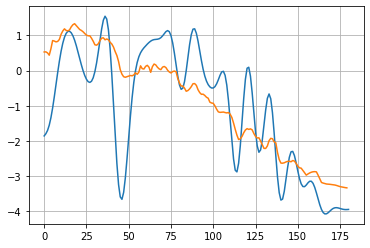

In [142]:
eta = 0.5

def LSE(x):
    return np.sum(np.square(v_impf[:-1] - (x[2]*force-x[0]*strain)/x[1]))

from scipy import optimize

minimum = optimize.fmin(LSE, x0=np.array([0.1,0.5,1]))
print(minimum)

v_imp_hat = (minimum[2]*force-minimum[0]*strain)/minimum[1]

plt.plot(v_impf)
plt.plot(v_imp_hat)
plt.grid()

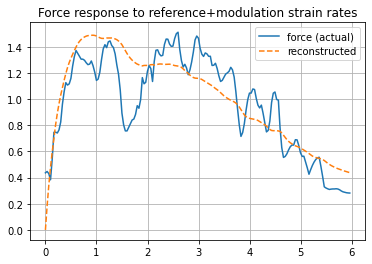

In [147]:
N = 180
dt = 0.0333
t = np.arange(0,N*dt,dt)

states = [0]

for i in range(t.shape[0]-1):
    states.append(v2f(states[-1],v_ref[i]/dt+v_imp_hat[i],dt))

plt.plot(t,force,label='force (actual)')
plt.plot(t,np.array(states),'--',label='reconstructed')
plt.grid(); plt.title('Force response to reference+modulation strain rates')
plt.legend()

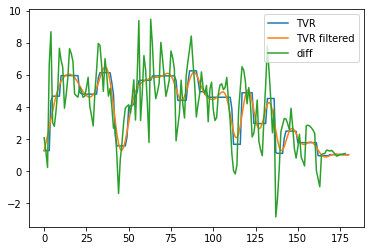

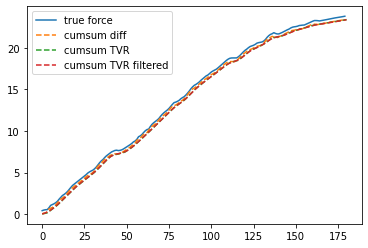

In [227]:
# Data
dx = dt
data_noisy = strain
n = len(data_noisy)

# Derivative with TVR
diff_tvr = DiffTVR(n,dx)
(dstrain,_) = diff_tvr.get_deriv_tvr(
    data=data_noisy, 
    deriv_guess=np.full(n+1,0.0), 
    alpha=0.01,
    no_opt_steps=100
    )

b, a = signal.ellip(4, 0.01, 120, 0.125)  # LPF
dstrainf = signal.filtfilt(b, a, dstrain, padlen=10)

# Plot TVR derivative
fig2 = plt.figure()
plt.plot(dstrain,label='TVR')
plt.plot(dstrainf,label='TVR filtered')
plt.plot(np.diff(strain)/dt,label='diff')
plt.legend()
plt.show()

integrated_diff = np.cumsum(np.diff(strain))
integrated_tvr = np.cumsum(dstrain*dt)
integrated_tvrf = np.cumsum(dstrainf*dt)

plt.plot(strain,label='true force')
plt.plot(integrated_diff,'--',label='cumsum diff')
plt.plot(integrated_tvr,'--',label='cumsum TVR')
plt.plot(integrated_tvrf,'--',label='cumsum TVR filtered')
plt.legend()
plt.show()

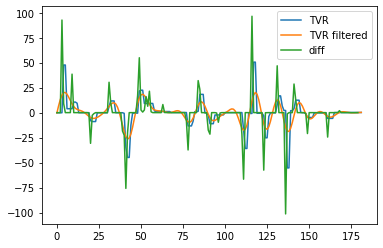

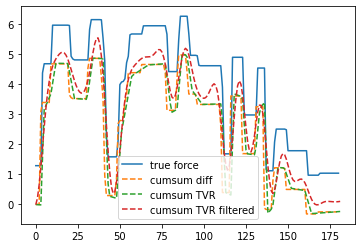

In [229]:
# Data
dx = dt
data_noisy = dstrain
n = len(data_noisy)

# Derivative with TVR
diff_tvr = DiffTVR(n,dx)
(ddstrain,_) = diff_tvr.get_deriv_tvr(
    data=data_noisy, 
    deriv_guess=np.full(n+1,0.0), 
    alpha=0.01,
    no_opt_steps=100
    )

b, a = signal.ellip(4, 0.01, 120, 0.125)  # LPF
ddstrainf = signal.filtfilt(b, a, ddstrain, padlen=10)

# Plot TVR derivative
fig2 = plt.figure()
plt.plot(ddstrain,label='TVR')
plt.plot(ddstrainf,label='TVR filtered')
plt.plot(np.diff(dstrain)/dt,label='diff')
plt.legend()
plt.show()

integrated_diff = np.cumsum(np.diff(dstrain))
integrated_tvr = np.cumsum(ddstrain*dt)
integrated_tvrf = np.cumsum(ddstrainf*dt)

plt.plot(dstrain,label='true force')
plt.plot(integrated_diff,'--',label='cumsum diff')
plt.plot(integrated_tvr,'--',label='cumsum TVR')
plt.plot(integrated_tvrf,'--',label='cumsum TVR filtered')
plt.legend()
plt.show()

In [234]:
dstrainf

array([1.28458443, 1.74373335, 2.22138199, 2.72471074, 3.24609895,
       3.76516832, 4.25594708, 4.69518296, 5.06807669, 5.36988349,
       5.60411146, 5.77908595, 5.90440427, 5.98809197, 6.03481948,
       6.04542321, 6.01786649, 5.94945194, 5.83963348, 5.69241338,
       5.51729289, 5.32822543, 5.14091822, 4.96971841, 4.82560635,
       4.71621479, 4.64763332, 4.62673382, 4.6623937 , 4.7644199 ,
       4.93996402, 5.1883418 , 5.4959516 , 5.83310547, 6.15409994,
       6.40115368, 6.51223455, 6.43217331, 6.12551922, 5.58838294,
       4.8556325 , 4.00008004, 3.12219865, 2.33203864, 1.72799577,
       1.37830119, 1.30992775, 1.50691794, 1.91744307, 2.46709982,
       3.07501842, 3.66901921, 4.196419  , 4.62847431, 4.95861193,
       5.19652703, 5.36094825, 5.47327501, 5.55308603, 5.61552216,
       5.67014499, 5.72093969, 5.76731556, 5.8060024 , 5.83356941,
       5.84898511, 5.85538014, 5.86019308, 5.87328173, 5.90326676,
       5.95309466, 6.01630608, 6.07558596, 6.10476097, 6.07452